In [1]:
import os
import glob
import time
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

observed_emotions = [
        'neutral',
        'calm',
        'happy',
        'sad',
        'angry',
        'fear',
        'disgust',
        'surprised']

In [3]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    result = np.array([]) 
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)

        # delta = librosa.feature.delta(mfccs)
        # delta_mean = np.mean(delta.T, axis=0)

        result = np.hstack((result, mfccs_mean))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    return result

In [4]:
def load_data(test_size=0.2): 
    x, y = [], []

    paths = [
        "audio/songs/Actor_*/**/*.wav",
        "audio/speech/Actor_*/**/*.wav"
    ]

    for path in paths:
        for file in glob.glob(path, recursive=True):
            file_name = os.path.basename(file)
            emotion_code = file_name.split("-")[2]
            emotion = emotions.get(emotion_code)
            if emotion not in observed_emotions:
                continue
            feature = extract_feature(file,mfcc=True, chroma=True, mel=True)
            x.append(feature)
            y.append(emotion)
    
    return {"X": x, "y": y}

In [5]:
start_time = time.time()
Trial_dict = load_data(test_size=0.2)
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))


--- Data loaded. Loading time: 122.14245843887329 seconds ---


In [6]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [7]:
data = pd.concat([X, y], axis=1)
data = data.reindex(np.random.permutation(data.index))

In [8]:
# Save to CSV
data.to_csv("RAVDESS_MFCC_Observed.csv")

In [9]:
start_time = time.time()
data = pd.read_csv('RAVDESS_MFCC_Observed.csv')
print("Data loaded in {:.2f} seconds".format(time.time() - start_time))

Data loaded in 0.08 seconds


In [10]:
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

In [11]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,0.1
0,-636.811890,18.038975,-20.638283,0.245430,-22.706905,-16.336475,-10.089888,-20.111998,-16.815048,1.922118,...,0.000079,0.000083,0.000073,0.000058,0.000022,0.000007,1.368401e-06,1.090016e-07,3.742255e-09,sad
1,-558.917603,49.529633,-17.215832,11.155218,-8.379954,-9.626589,-12.273407,-13.040263,-20.412863,4.617065,...,0.000311,0.000322,0.000276,0.000133,0.000047,0.000015,2.794844e-06,3.309688e-07,1.552295e-08,fear
2,-705.064453,49.672398,3.551122,10.841411,-1.607606,1.537340,-4.919150,-8.724339,-8.667334,-0.039239,...,0.000028,0.000023,0.000025,0.000018,0.000006,0.000002,3.376824e-07,3.059119e-08,7.628637e-10,calm
3,-483.314636,45.982857,-8.965489,9.997782,-4.511325,0.926763,-5.717176,-0.725424,-14.467844,-1.944026,...,0.000917,0.000716,0.000804,0.000642,0.000189,0.000057,1.479087e-05,1.678640e-06,5.382895e-08,fear
4,-453.629639,19.266693,-23.883059,-2.707417,-14.595982,-10.354134,-14.671471,-8.896213,-25.870417,1.429994,...,0.001027,0.000869,0.000799,0.000812,0.000468,0.000145,2.617286e-05,1.837476e-06,6.183508e-08,happy


In [12]:
print(data.columns)


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '171', '172', '173', '174', '175', '176', '177', '178', '179', '0.1'],
      dtype='object', length=181)


In [13]:
# Rename the last column to 'emotion'
data.rename(columns={data.columns[-1]: 'emotion'}, inplace=True)

X = data.drop('emotion', axis=1).values
y = data['emotion'].values


In [14]:
print(data.head())
print(data.columns.tolist())


            0          1          2          3          4          5  \
0 -636.811890  18.038975 -20.638283   0.245430 -22.706905 -16.336475   
1 -558.917603  49.529633 -17.215832  11.155218  -8.379954  -9.626589   
2 -705.064453  49.672398   3.551122  10.841411  -1.607606   1.537340   
3 -483.314636  45.982857  -8.965489   9.997782  -4.511325   0.926763   
4 -453.629639  19.266693 -23.883059  -2.707417 -14.595982 -10.354134   

           6          7          8         9  ...       171       172  \
0 -10.089888 -20.111998 -16.815048  1.922118  ...  0.000079  0.000083   
1 -12.273407 -13.040263 -20.412863  4.617065  ...  0.000311  0.000322   
2  -4.919150  -8.724339  -8.667334 -0.039239  ...  0.000028  0.000023   
3  -5.717176  -0.725424 -14.467844 -1.944026  ...  0.000917  0.000716   
4 -14.671471  -8.896213 -25.870417  1.429994  ...  0.001027  0.000869   

        173       174       175       176           177           178  \
0  0.000073  0.000058  0.000022  0.000007  1.368401e-06

In [15]:
print("X shape:", X.shape)
print("Unique labels:", np.unique(y))

X shape: (2452, 180)
Unique labels: ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprised']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
print("\nTraining SVM without scaling...")
svm_unscaled = SVC(kernel='linear')
start = time.time()
svm_unscaled.fit(X_train, y_train)
print("Trained in {:.2f} seconds".format(time.time() - start))


Training SVM without scaling...
Trained in 21.80 seconds



Classification Report (Unscaled):
               precision    recall  f1-score   support

       angry       0.67      0.72      0.69        61
        calm       0.57      0.74      0.65        78
     disgust       0.47      0.44      0.45        39
        fear       0.64      0.56      0.60        81
       happy       0.62      0.51      0.56        79
     neutral       0.46      0.51      0.49        35
         sad       0.59      0.54      0.56        81
   surprised       0.44      0.46      0.45        37

    accuracy                           0.58       491
   macro avg       0.56      0.56      0.56       491
weighted avg       0.58      0.58      0.57       491

Accuracy (Unscaled): 57.64%


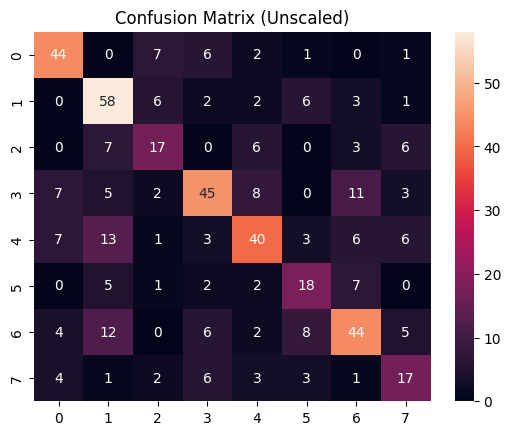

In [18]:
y_pred_unscaled = svm_unscaled.predict(X_test)
print("\nClassification Report (Unscaled):\n", classification_report(y_test, y_pred_unscaled))
print("Accuracy (Unscaled): {:.2f}%".format(accuracy_score(y_test, y_pred_unscaled) * 100))


cm_unscaled = confusion_matrix(y_test, y_pred_unscaled)
sn.heatmap(pd.DataFrame(cm_unscaled), annot=True, fmt='d')
plt.title("Confusion Matrix (Unscaled)")
plt.show()

In [19]:
print("\nTraining SVM with scaling (Pipeline)...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])
pipeline.fit(X_train, y_train)


Training SVM with scaling (Pipeline)...


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(kernel='linear'))])

In [20]:
y_pred_scaled = pipeline.predict(X_test)
print("\nClassification Report (Scaled):\n", classification_report(y_test, y_pred_scaled))
print("Accuracy (Scaled): {:.2f}%".format(accuracy_score(y_test, y_pred_scaled) * 100))




Classification Report (Scaled):
               precision    recall  f1-score   support

       angry       0.59      0.72      0.65        61
        calm       0.57      0.76      0.65        78
     disgust       0.44      0.44      0.44        39
        fear       0.70      0.54      0.61        81
       happy       0.61      0.47      0.53        79
     neutral       0.50      0.51      0.51        35
         sad       0.58      0.48      0.53        81
   surprised       0.41      0.51      0.46        37

    accuracy                           0.56       491
   macro avg       0.55      0.55      0.55       491
weighted avg       0.57      0.56      0.56       491

Accuracy (Scaled): 56.42%


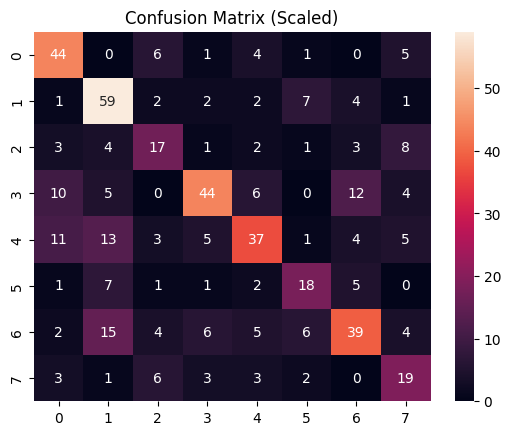

In [21]:
cm_scaled = confusion_matrix(y_test, y_pred_scaled)
sn.heatmap(pd.DataFrame(cm_scaled), annot=True, fmt='d')
plt.title("Confusion Matrix (Scaled)")
plt.show()

In [22]:
print("\nCross-validation accuracy scores (5-fold):")
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(cv_scores)
print("Mean CV accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))


Cross-validation accuracy scores (5-fold):
[0.57841141 0.60488798 0.62244898 0.58163265 0.55714286]
Mean CV accuracy: 58.89%


In [23]:
train_acc = pipeline.score(X_train, y_train) * 100
test_acc = pipeline.score(X_test, y_test) * 100
print("Train Accuracy (Scaled): {:.2f}%".format(train_acc))
print("Test Accuracy (Scaled): {:.2f}%".format(test_acc))

Train Accuracy (Scaled): 81.80%
Test Accuracy (Scaled): 56.42%


In [24]:
pipeline = Pipeline([
    # ('select', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {
    'svm__kernel': ['linear', 'rbf'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy: {:.2f}%".format(grid.best_score_ * 100))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 70.27%


In [25]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


              precision    recall  f1-score   support

       angry       0.80      0.87      0.83        61
        calm       0.68      0.83      0.75        78
     disgust       0.76      0.64      0.69        39
        fear       0.71      0.64      0.68        81
       happy       0.77      0.62      0.69        79
     neutral       0.58      0.71      0.64        35
         sad       0.69      0.63      0.66        81
   surprised       0.63      0.73      0.68        37

    accuracy                           0.71       491
   macro avg       0.70      0.71      0.70       491
weighted avg       0.71      0.71      0.71       491

Test Accuracy: 70.67%
